In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

In [16]:
stock_symbol = 'FB' # Stock Symbol Google / Alphabet
# last 5 years data with interval 1 day
data = yf.download(tickers=stock_symbol, period='10y', interval='1d')
s = pd.Series(list(range(0, len(data))))
data.set_index(s, inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
0,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
1,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
3,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
4,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


In [17]:
data_training_size = int(len(data)*0.7)
data_test_size = len(data) - data_training_size
data_training, data_test = data.iloc[0:data_training_size,:], data.iloc[data_training_size:len(data),:]
data_training = data_training.drop(['Adj Close'], axis=1)
data_test = data_test.drop(['Adj Close'], axis=1)
data_training.head()

,Open,High,Low,Close,Volume
0,42.049999,45.000000,38.000000,38.230000,573576400
1,36.529999,36.660000,33.000000,34.029999,168192700
2,32.610001,33.590000,30.940001,31.000000,101786600
3,31.370001,32.500000,31.360001,32.000000,73600000
4,32.950001,33.209999,31.770000,33.029999,50237200


In [18]:
sc = MinMaxScaler()
training_data = sc.fit_transform(data_training)
training_data

array([[0.12128111, 0.13341652, 0.10395486, 0.10261801, 1.        ],
       [0.09335154, 0.09178937, 0.07853803, 0.08159383, 0.28587298],
       [0.07351751, 0.07646618, 0.06806629, 0.06642639, 0.16889149],
       ...,
       [0.63180528, 0.63104567, 0.6289142 , 0.63322819, 0.02870152],
       [0.63246307, 0.6303469 , 0.62672831, 0.63307803, 0.01798936],
       [0.63281721, 0.63433992, 0.63552259, 0.63107575, 0.01232227]])

In [19]:
window = 60# check that window is less than shape[0]
x_train = []
y_train = []
for i in range(window, training_data.shape[0]):
    # take from current minus 60 first dimension, empty seconds dimension to grab all 5
    x_train.append(training_data[i-window:i])
    y_train.append(training_data[i, 0]) # zero second dimension only to grab which result should be
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((1613, 60, 5), (1613,))

In [20]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(x_train.shape[1], 5)),
    keras.layers.Bidirectional(
        keras.layers.LSTM(units=80, activation='relu', return_sequences=True),
    ),
    keras.layers.Dropout(0.2),
    keras.layers.Bidirectional(
        keras.layers.LSTM(units=80, activation='relu', return_sequences=True),
    ),
    keras.layers.Dropout(0.3),
    keras.layers.Bidirectional(
        keras.layers.LSTM(units=80, activation='relu', return_sequences=True),
    ),
    keras.layers.Dropout(0.4),
    # the last one never must have return sequences true, bc you dont want your input to be the output
    # you want only a result
    keras.layers.Bidirectional(
        keras.layers.LSTM(units=120, activation='relu'),
    ),
    keras.layers.Dropout(0.5),
    # output layer, dense layer, return one result -> units
    keras.layers.Dense(units=1)
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 60, 160)           55040     
_________________________________________________________________
dropout_20 (Dropout)         (None, 60, 160)           0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 60, 160)           154240    
_________________________________________________________________
dropout_21 (Dropout)         (None, 60, 160)           0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 60, 160)           154240    
_________________________________________________________________
dropout_22 (Dropout)         (None, 60, 160)           0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 240)              

In [21]:
model.compile(
    optimizer='adam', #already does a batch aproach, re listen the podcast to remember later
    # adam algorithm is stochastic gradient decent, using batch but different from SGD uses adam algorithm to optimize
    loss = 'mean_squared_error'
)
model.fit(x_train, y_train, epochs=10, batch_size=32)

2021-11-17 10:24:48.070046: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-17 10:24:48.072987: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2021-11-17 10:24:49.687034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 1244s 24s/step - loss: 0.0354
Epoch 2/10
51/51 [==============================] - 1219s 24s/step - loss: 0.0062
Epoch 3/10
51/51 [==============================] - 1209s 24s/step - loss: 0.0053
Epoch 4/10
51/51 [==============================] - 1229s 24s/step - loss: 0.0047
Epoch 5/10
51/51 [==============================] - 1239s 24s/step - loss: 0.0054
Epoch 6/10
51/51 [==============================] - 1218s 24s/step - loss: 0.0040
Epoch 7/10
51/51 [==============================] - 1234s 24s/step - loss: 0.0038
Epoch 8/10
51/51 [==============================] - 1224s 24s/step - loss: 0.0036
Epoch 9/10
51/51 [==============================] - 1232s 24s/step - loss: 0.0034
Epoch 10/10
51/51 [==============================] - 1264s 25s/step - loss: 0.0042


In [22]:
past_window_days = data_training.tail(window)
# get window size of previous data to continue from the training data to the test data
# that way we put a link between test and time line data

df = past_window_days.append(data_test, ignore_index = True)
df

,Open,High,Low,Close,Volume
0,155.399994,159.460007,155.009995,158.779999,19180100
1,159.559998,160.490005,157.949997,159.419998,17592000
2,158.509995,158.660004,153.279999,154.919998,21675100
3,155.860001,157.350006,153.550003,154.050003,19761300
4,154.759995,157.339996,154.460007,154.779999,15424700
...,...,...,...,...,...
773,332.489990,333.190002,325.510010,327.640015,21872600
774,329.820007,332.459991,327.000000,327.739990,12376600
775,330.179993,341.859985,329.779999,340.890015,25387200
776,344.339996,353.649994,343.200012,347.559998,25076600


In [23]:
inputs = sc.transform(df) # we transfor the data into an array and then gather the window sizes with the prediction

x_test = []
y_test = []
for i in range(window, inputs.shape[0]):
    # take from current minus 60 first dimension, empty seconds dimension to grab all 5
    x_test.append(inputs[i-window:i])
    y_test.append(inputs[i, 0]) # zero second dimension only to grab which result should be
x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, y_test.shape

((718, 60, 5), (718,))

In [24]:
y_pred = model.predict(x_test)

# un scale the values to normal amount of google shares
scale = (1/sc.scale_[0]) # scaling label -> amount that use scaler to scale
# every single value of scale_ is the factor that was use for every single value in the scaler
# sc.scale_[0] is the scaler factor
# we do the 1/scale to do the reverse and have the original numbers
sc.scale_, sc.scale_[0], scale

y_pred_final = y_pred*scale
y_test_final = y_test*scale
# normal scales

2021-11-17 13:50:01.815926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


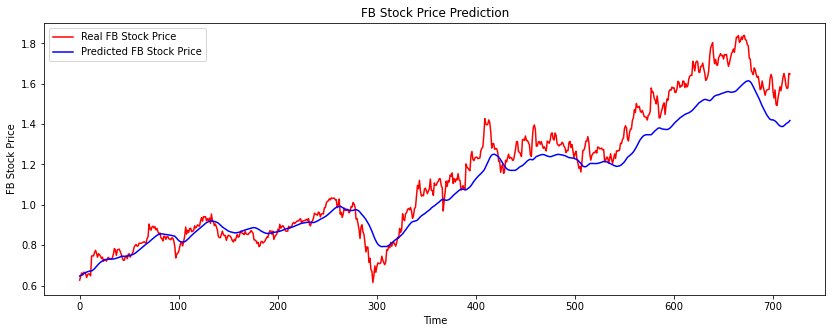

In [25]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color='red', label='Real FB Stock Price')
plt.plot(y_pred, color='blue', label='Predicted FB Stock Price')
plt.title('FB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.show()

In [26]:
model.evaluate(x_test, y_test)

2021-11-17 13:50:28.484632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 26s 1s/step - loss: 0.0101


0.01009933091700077